In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

from cmdstanpy import CmdStanModel
import arviz as az

In [118]:
#data = pd.read_csv('./dataStore/datas_2_ref.csv',index_col=0)

data = pd.read_csv('./dataStore/microrheology.csv',index_col=0)

names = {'AlgVLVG0_0Ca_2mgmlcollagen':'Collagen',
        'AlgLVLG15_3Ca_2mgmlcollagen':'IPN soft',
        'AlgVLVG15_22Ca_2mgmlcollagen':'IPN medium',
        'AlgVLVG15_40Ca_2mgmlcollagen':'IPN stiff'}

data['type'] = data['type'].apply(lambda x: names[x])

In [15]:
# create a Boolean mask for the rows to remove
mask = data['type'] == 'IPN stiff'

# select all rows except the ones that contain 'Coca Cola'
data = data[~mask].reset_index(drop=True)
data["size"].astype("int")

0      10
1      10
2      10
3      10
4      10
       ..
551    50
552    50
553    50
554    50
555    50
Name: size, Length: 556, dtype: int32

In [32]:
def _gen_indices(data,names,idx,indices,orig_indices):
    # generate running indices based on the hierarchy
    
    # break recursion if at the end of hierarchy
    if idx>=len(names):
        return indices,orig_indices
    for ii,i in data.groupby(names[idx]):
        counts = i.shape[0]
        latest = 1
        l = indices[names[idx]]
        if len(l) != 0:
            latest = l[-1]+1
        # add running indices to the current level hierarchy
        indices[names[idx]].extend([latest]*counts)
        orig_indices[names[idx]].extend([ii]*counts)
        indices,orig_indices = _gen_indices(i,names,idx+1,indices,orig_indices)
    return indices,orig_indices

def index(name):
    # index vector outside hierarchy
    indices = np.zeros(data.shape[0],dtype=int)
    orig = np.zeros(data.shape[0],dtype=object)
    for idx,i in enumerate(np.unique(data[name])):
        mask = data[name]==i
        indices[mask] = idx
        orig[mask] = i
    return indices,orig

In [33]:
# hierarcical indexing
gnames = ['type','day','sample','holder','location','track_id']
g_indices = {i:[] for i in gnames}
g_orig_indices = {i:[] for i in gnames}

indices,orig_indices = _gen_indices(data,gnames,0,g_indices,g_orig_indices)

# outside hierarchy
size_indices,size_orig = index('size')
coating_indices,coating_orig = index('coating')

In [34]:
# relative scaling
#normalize = lambda x: data[x].sub(data.groupby('type')[x].transform('mean'))\
#             .div(data.groupby('type')[x].transform('std'))

# global scaling
#normalize = lambda x: data[x].sub(data.groupby('type')[x].transform('mean'))\
#             .div(data[x].std())

# global scaling
#normalize = lambda x: data[x].sub(data[x].mean())\
#             .div(data[x].std())

normalize = lambda x: data[x]\
             .div(data[x].std())

data['G_abs_normed'] = normalize('G_abs')
data['phi_normed'] = normalize('phi_(rad)')
data['radius_(m)'] = normalize('radius_(m)')

In [36]:
data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
             **{f'{i}_ids':j for i,j in indices.items()},
             'y':data['G_abs_normed'].tolist(),
             'N':data.shape[0]}

#data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
#             **{f'{i}_ids':j for i,j in indices.items()},
#             'size_ids':(size_indices+1).tolist(),
#             'N_size':len(np.unique(size_indices)),
#             'y':data['G_abs_normed'].tolist(),
#             'N':data.shape[0]}


with open('./dataStore/data.json','w') as f:
    json.dump(data_json,f)

In [27]:
model = CmdStanModel(stan_file='./model/model_o.stan')
fit = model.sample(data='./dataStore/data.json', show_progress=True,adapt_delta=0.99,max_treedepth=15)
print(fit.diagnose())

INFO:cmdstanpy:compiling stan file C:\Users\lehtona6\codes\InstruProject\microrheology\model\model_o.stan to exe file C:\Users\lehtona6\codes\InstruProject\microrheology\model\model_o.exe
INFO:cmdstanpy:compiled model executable: C:\Users\lehtona6\codes\InstruProject\microrheology\model\model_o.exe
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:18 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |██▎       | 00:29 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:39 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:45 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:52 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:57 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 01:02 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 01:12 Iteration:  900 / 2000 [ 45%]  (Warmup)






INFO:cmdstanpy:CmdStan done processing.



Processing csv files: C:\Users\lehtona6\AppData\Local\Temp\tmp3w38f36f\model_o-20241226101944_1.csv, C:\Users\lehtona6\AppData\Local\Temp\tmp3w38f36f\model_o-20241226101944_2.csv, C:\Users\lehtona6\AppData\Local\Temp\tmp3w38f36f\model_o-20241226101944_3.csv, C:\Users\lehtona6\AppData\Local\Temp\tmp3w38f36f\model_o-20241226101944_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [28]:
az_sample = az.from_cmdstanpy(fit,posterior_predictive='y_hat',
                        log_likelihood='log_likelihood',
                        observed_data={'y':data_json['y']})

In [58]:
name_list = ['Collagen','IPN soft', 'IPN medium' ]

vals = fit.draws_pd().filter(regex='^sigma_holder')
vals.columns =  name_list #,'IPN stiff'

In [71]:

def comp(name1,name2,df):
    a = df[name1].values
    b = df[name2].values
    r = np.sum((a-b)>0)/a.shape[0]
    label = 'P( {} > {} ) = {:.4f}'.format(name1,name2,r)
    return r

def comp_all(names,df):
    probs = {}
    for i in names:
        probs[i] = {}
        for j in names:
            #if i != j:
            probs[i][j] = comp(i,j,df)
    return probs

probabilities = comp_all(name_list, vals)

C:\Users\lehtona6\AppData\Local\Temp\ipykernel_2664\3015672904.py:16: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= data, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')
C:\Users\lehtona6\AppData\Local\Temp\ipykernel_2664\3015672904.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])
C:\Users\lehtona6\AppData\Local\Temp\ipykernel_2664\3015672904.py:21: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= data, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')
C:\Users\lehtona6\AppData\Local\Temp\ipykernel_2664\3015672904.py:23: UserWarning: se

(0.0, 1.0, 0.0, 1.0)

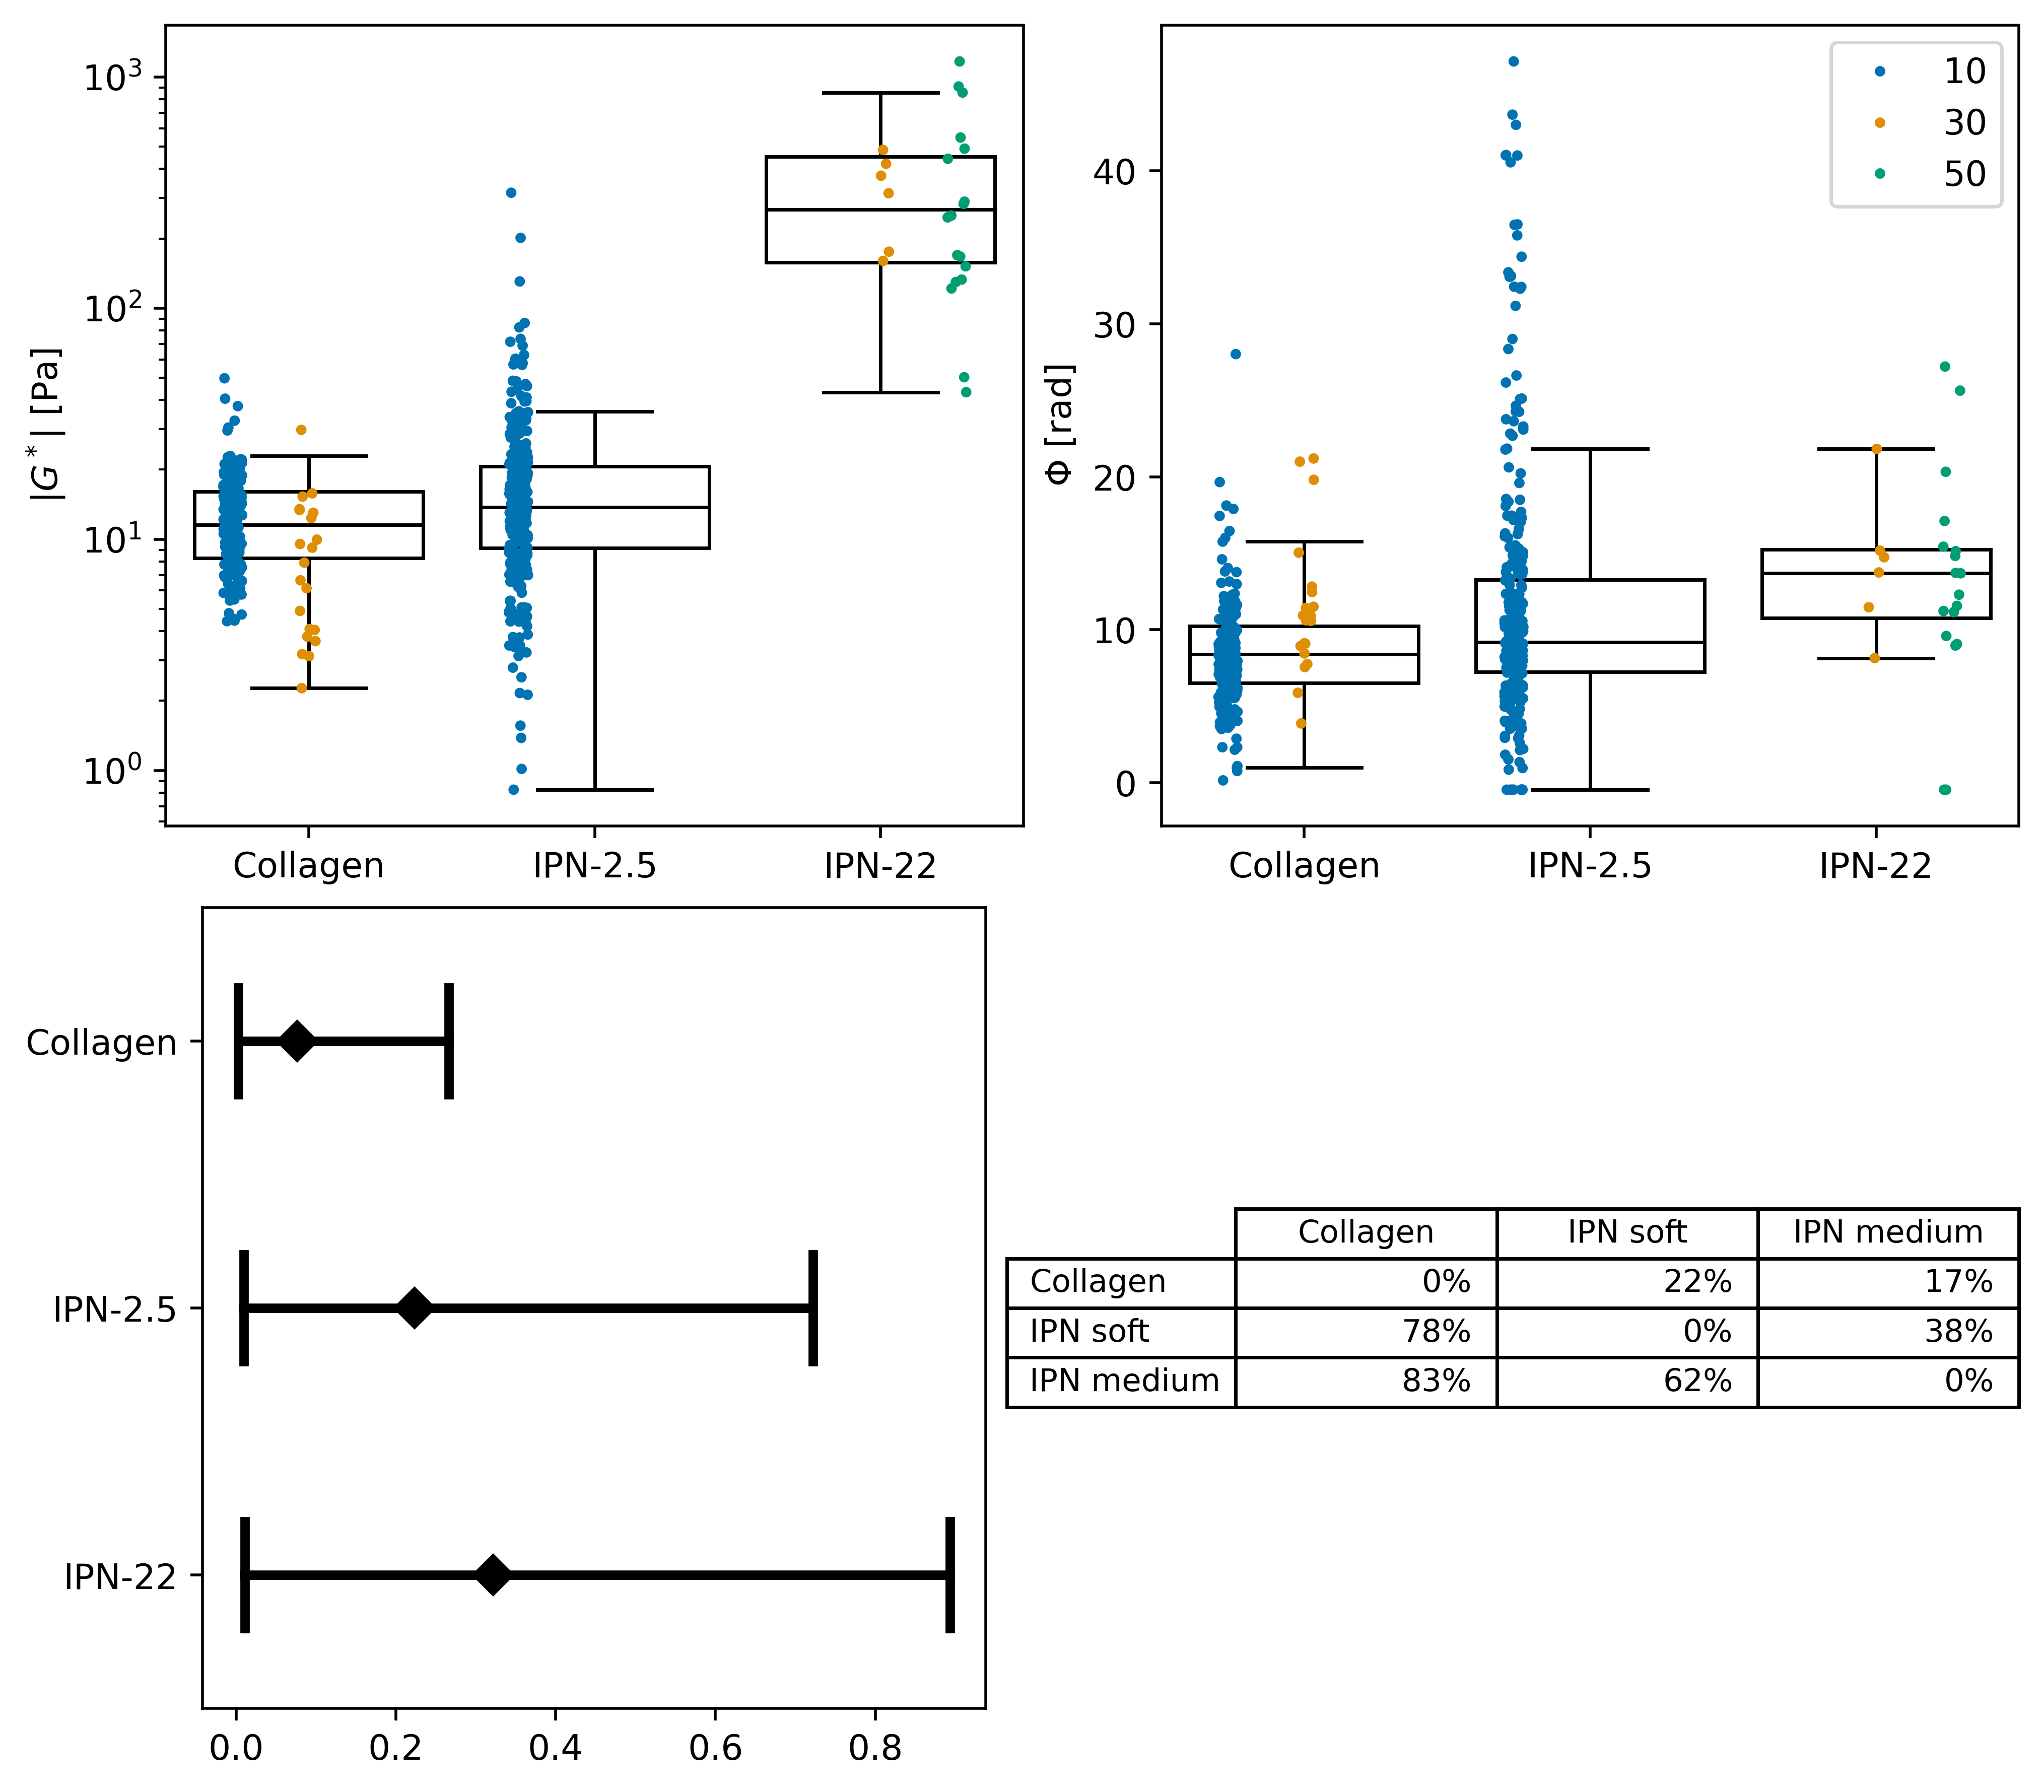

In [110]:
fig = plt.figure(constrained_layout=True, figsize=(8,7),dpi = 500)
subfigs = fig.subfigures(2, 1, wspace=0.0025, hspace=0.0025, height_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 2)
ax2 = subfigs[1].subplots(1, 2)



PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
sns.boxplot(data=data,x='type', y='G_abs',ax=ax1[0], showfliers= False, **PROPS)
sns.stripplot(data= data, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])

sns.boxplot(data=data,x='type', y='phi_(deg)',ax=ax1[1], showfliers = False, **PROPS)
sns.stripplot(data= data, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[1].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[0].set_title('')
ax1[1].set_title('')
ax1[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax1[1].set_ylabel(r'${}$ [{}]'.format('\Phi','rad'))
ax1[0].set_xlabel("")
ax1[1].set_xlabel("")
ax1[1].legend()
ax1[0].set_yscale("log")

df = vals.melt()
sns.pointplot(
    data=df, x="value", y="variable",
    errorbar=("pi", 95), capsize=.4,
    color="black", linestyle="none", marker="D", ax=ax2[0]
)
ax2[0].set_ylabel("")
ax2[0].set_xlabel("")
ax2[0].set_yticklabels(["Collagen", "IPN-2.5", "IPN-22"])


columns = name_list
rows = name_list

# Plot bars and create text labels for the table
cell_text = []
for col_ in columns:
    row_text = []
    for row_ in rows:
        row_text.append(r"{}$\%$".format(int(np.round(probabilities[col_][row_]*100,0))))
    cell_text.append(row_text)

# Reverse colors and text labels to display the last value at the top.
#cell_text.reverse()

# Add a table at the bottom of the Axes
the_table = ax2[1].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')

ax2[1].axis("off")
#fig.tight_layout()

#fig.savefig("./NikonPipes/dataStore/microrheology.png",transparent=False,facecolor='white' )


(0.0, 1.0)

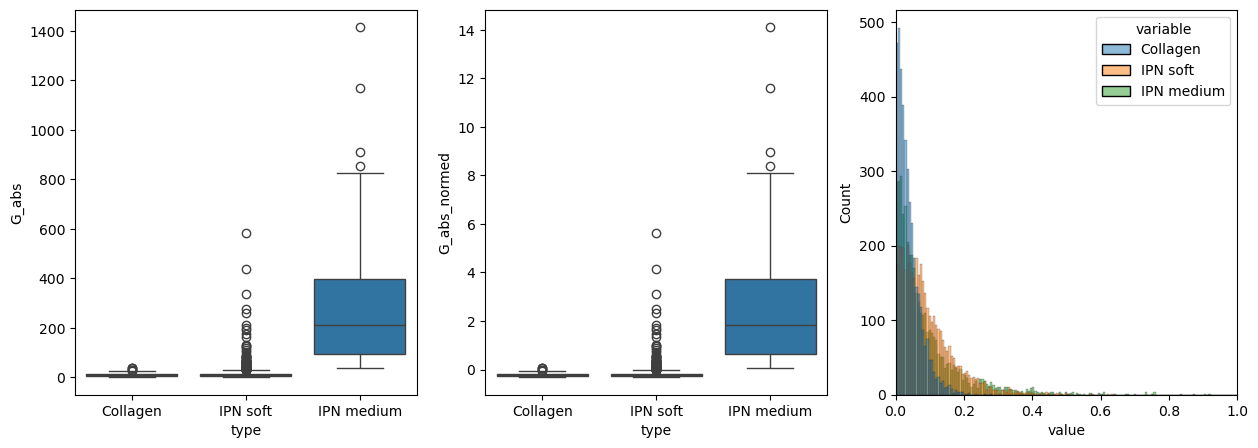

In [73]:
fig,ax = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(data=data,y='G_abs',x='type',ax=ax[0])

sns.boxplot(data=data,y='G_abs_normed',x='type',ax=ax[1])

sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[2])
ax[2].set_xlim(0,1)

10um    0.017135
30um    0.057995
50um    0.627960
dtype: float64


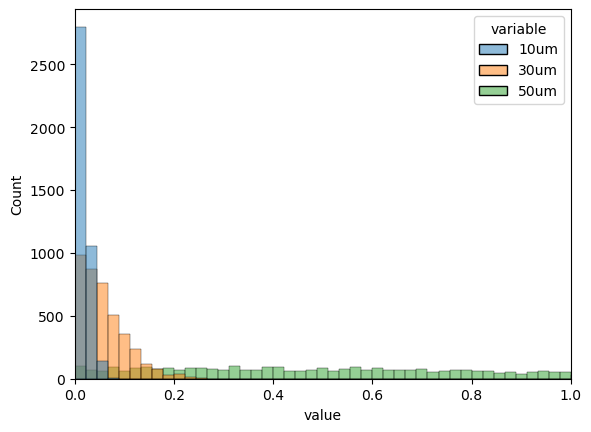

In [146]:
vals = fit.draws_pd().filter(regex='^sigma_size')
vals.columns = ['10um', "30um",'50um' ] #,'IPN stiff'

fig,ax = plt.subplots()
sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax)
ax.set_xlim(0,1)
print(vals.mean(axis=0))

collagen     -0.016508
IPN_soft      0.045460
IPN medium    0.307893
dtype: float64


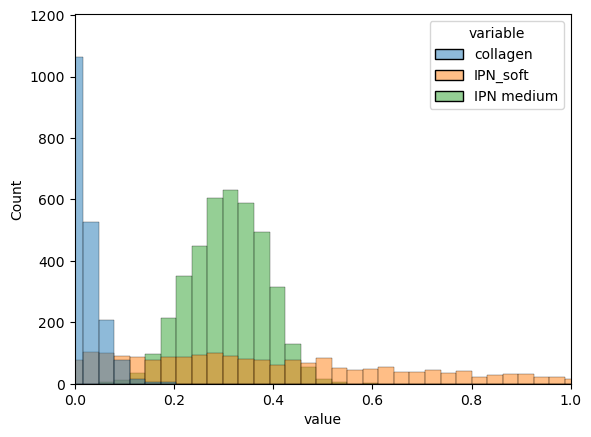

In [142]:
vals = fit.draws_pd().filter(regex='^alpha')
vals.columns = ['collagen', "IPN_soft",'IPN medium' ] #,'IPN stiff'

fig,ax = plt.subplots()
sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax)
ax.set_xlim(0,1)
print(vals.mean(axis=0))

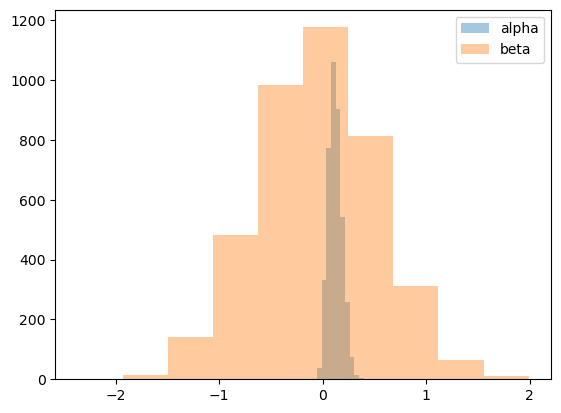

In [134]:
_ = plt.hist(fit.draws_pd().filter(regex='^alpha'), alpha =0.4, label="alpha")
_ = plt.hist(fit.draws_pd().filter(regex='^beta'), alpha =0.4, label="beta")
plt.legend()

In [52]:
track_indices,counts = np.unique(indices['track_id'],return_counts=True)

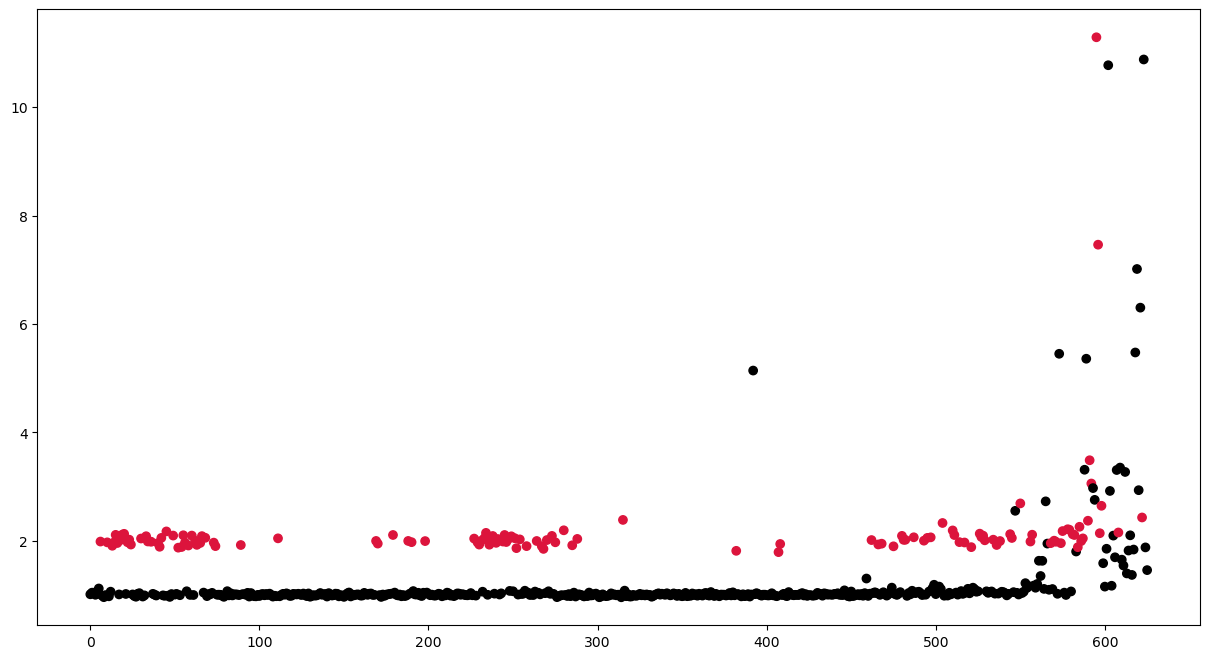

In [53]:
fig = plt.figure(figsize=(15,8))
cols = ['crimson' if i==1 else 'black' for i in counts]
plt.scatter(np.arange(sigmas.shape[1]),sigmas.mean(axis=0).values,c=cols)

In [54]:
print(data.groupby(['type','day','sample','holder','location','track_id'])[['G_abs']].std().to_string())

                                                        G_abs
type       day    sample holder location track_id            
Collagen   211029 10     10     10       0           0.162056
                                         1           5.886139
                                         2           2.722900
                                         3           3.999497
                                         4           1.578650
                                         5           0.655281
           240325 1      1      1        0                NaN
                                         2           0.618805
                                         3           2.262209
                                         4           0.146275
                                         7                NaN
                                         10          2.004349
                                         11          0.988177
                                2        0                NaN
        

In [55]:
np.median(data.groupby(['type','day','sample','holder','location','track_id'])['G_abs'].apply(lambda x: np.nanstd(x)))

0.32984265447842775

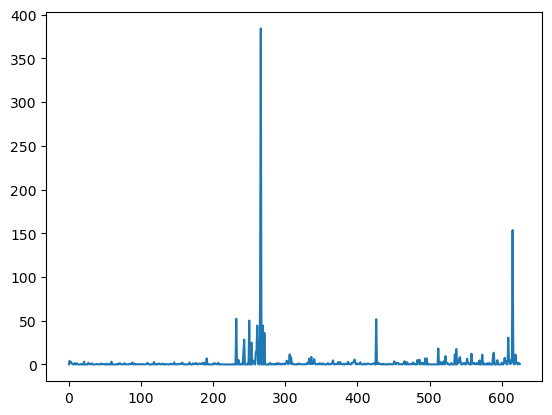

In [56]:
plt.plot(data.groupby(['type','day','sample','holder','location','track_id'])['G_abs'].apply(lambda x: np.nanstd(x)).values)

In [111]:
# hierarcical indexing
gnames = ['type','day','sample','holder','location','track_id']
g_indices = {i:[] for i in gnames}
g_orig_indices = {i:[] for i in gnames}

indices,orig_indices = _gen_indices(data,gnames,0,g_indices,g_orig_indices)

# outside hierarchy
size_indices,size_orig = index('size')
coating_indices,coating_orig = index('coating')

normalize = lambda x: data[x]\
             .div(data[x].std())

data['G_abs_normed'] = normalize('G_abs')
data['phi_normed'] = normalize('phi_(rad)')
data['radius_(m)'] = normalize('radius_(m)')

data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
             **{f'{i}_ids':j for i,j in indices.items()},
             'x_size':data["radius_(m)"].tolist(),
             'y':data['G_abs_normed'].tolist(),
             'N':data.shape[0]}


with open('./dataStore/data_s.json','w') as f:
    json.dump(data_json,f)



In [112]:

model = CmdStanModel(stan_file='./model/model_o_linear_size.stan')
fit = model.sample(data='./dataStore/data_s.json', show_progress=True,adapt_delta=0.99,max_treedepth=15)
print(fit.diagnose())

INFO:cmdstanpy:compiling stan file C:\Users\lehtona6\codes\InstruProject\microrheology\model\model_o_linear_size.stan to exe file C:\Users\lehtona6\codes\InstruProject\microrheology\model\model_o_linear_size.exe
INFO:cmdstanpy:compiled model executable: C:\Users\lehtona6\codes\InstruProject\microrheology\model\model_o_linear_size.exe
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:09 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:19 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:23 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:30 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:33 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:37 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:40 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:44 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |█████     | 00:53 Iter


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: C:\Users\lehtona6\AppData\Local\Temp\tmp3w38f36f\model_o_linear_size-20241226124658_1.csv, C:\Users\lehtona6\AppData\Local\Temp\tmp3w38f36f\model_o_linear_size-20241226124658_2.csv, C:\Users\lehtona6\AppData\Local\Temp\tmp3w38f36f\model_o_linear_size-20241226124658_3.csv, C:\Users\lehtona6\AppData\Local\Temp\tmp3w38f36f\model_o_linear_size-20241226124658_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



(0.0, 1.0)

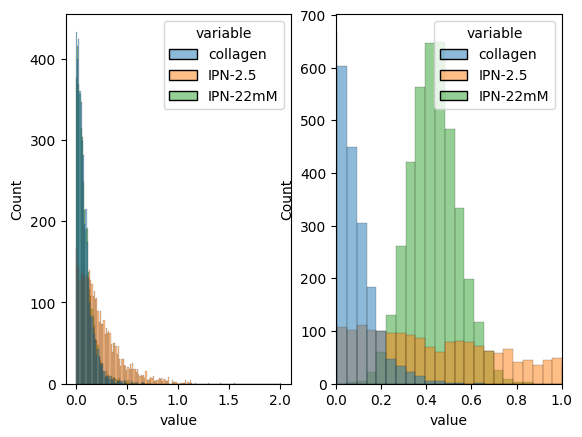

In [114]:

fig,ax = plt.subplots(1,2)

vals = fit.draws_pd().filter(regex='^sigma_holders')
vals.columns = ['collagen', "IPN-2.5",'IPN-22mM' ] #,'IPN stiff'

sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[0])


vals = fit.draws_pd().filter(regex='^alpha')
vals.columns = ['collagen', "IPN-2.5",'IPN-22mM' ] #,'IPN stiff'

sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[1])
ax[1].set_xlim(0,1)

<Axes: xlabel='type', ylabel='G_abs'>

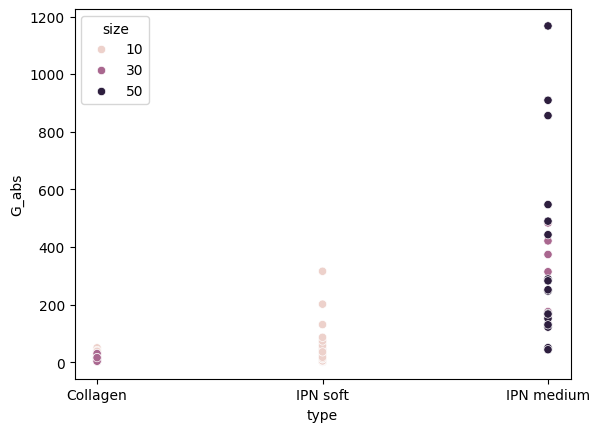

In [116]:
sns.scatterplot(data = data, x= "type", y= "G_abs", hue = "size")

In [119]:
data[data["type"] == "IPN soft"]["size"].unique()

array([10], dtype=int64)